Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed

Final Results:
R² Score: 0.8584
MSE: 136.1313
RMSE: 11.6675


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres

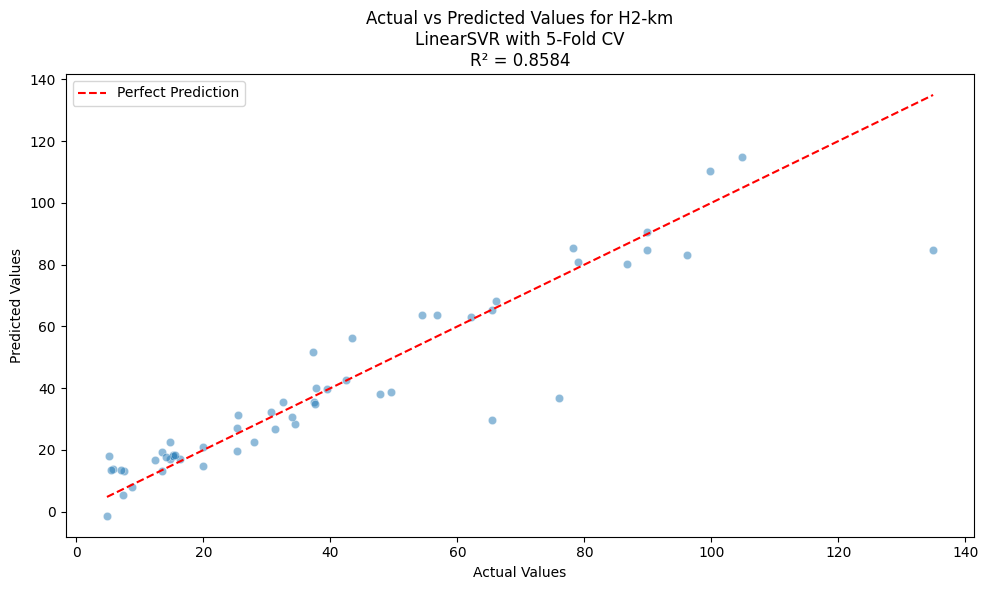

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def run_linearsvr_cv(data_path, target="ACE-km"):
    # Load the data
    df = pd.read_csv(data_path)

    # Define target columns
    target_columns = [
        "Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", "H2-Xi", "H2-km", "H2-Ks",
        "Digester_BD", "Digester_BF", "Digester_CB", "Digester_CP", "Digester_FD", "Digester_GB",
        "Digester_GP", "Digester_JB", "Digester_LP", "Digester_MA", "Digester_NB", "Digester_NS",
        "Digester_PC", "Digester_PO", "Digester_SF", "Digester_SS", "Digester_SW", "Digester_WA",
        "Digester_WP", "Digester_WR", "Source_I", "Source_M", "Source_P", "Type_CSTR", "Type_EFB",
        "Type_EGSB", "Type_Lagoon", "Type_UASB", "Waste_BW", "Waste_Dairy", "Waste_FW", "Waste_HSI",
        "Waste_MPW", "Waste_MS", "Waste_MS+Dairy", "Waste_MS+HSI", "Waste_PP", "Waste_PR",
        "Waste_SDW", "Biomass_F", "Biomass_G"
    ]

    # Get numerical columns (features)
    num_cols = [col for col in df.columns if col not in target_columns]

    # Remove any rows with 'x' values
    df = df[~df.isin(['x']).any(axis=1)]

    # Convert all data to numeric
    df = df.apply(pd.to_numeric, errors='coerce')

    # Split features and target
    X = df[num_cols]
    y = df[target]

    # Initialize K-Fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    # Initialize lists to store all predictions and actual values
    all_predictions = []
    all_actual = []

    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # Split data
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        # Scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Initialize and train model
        model = LinearSVR(random_state=42)
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_val_scaled)
        
        # Store predictions and actual values
        all_predictions.extend(y_pred)
        all_actual.extend(y_val)
        
        print(f"Fold {fold+1} completed")

    # Calculate final metrics using all predictions
    final_r2 = r2_score(all_actual, all_predictions)
    final_mse = mean_squared_error(all_actual, all_predictions)
    final_rmse = np.sqrt(final_mse)

    print("\nFinal Results:")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    # Create scatter plot of predicted vs actual values
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=all_actual, y=all_predictions, alpha=0.5)
    plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target}\nLinearSVR with 5-Fold CV\nR² = {final_r2:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Save results to CSV
    results_df = pd.DataFrame({
        'Actual': all_actual,
        'Predicted': all_predictions
    })
    results_df.to_csv(f'linearsvr_results_{target}.csv', index=False)

    return final_r2, final_mse, final_rmse, results_df

if __name__ == "__main__":
    data_path = "../Data/New_data.csv"
    target = "H2-km"  # You can change this to any target from target_columns
    r2, mse, rmse, results = run_linearsvr_cv(data_path, target) 

In [20]:
import pandas as pd
import numpy as np

def create_classified_dataset(input_path, output_path):
    # Load the original dataset
    df = pd.read_csv(input_path)
    
    # Remove 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop('Unnamed: 0', axis=1)
    
    # Define the key features and their classifications
    key_features = {
        'd__Archaea;p__Halobacterota;c__Methanosarcinia;o__Methanosarciniales;f__Methanosaetaceae;g__Methanosaeta': 'acetoclastic',
        'd__Archaea;p__Halobacterota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanoregulaceae;g__Methanolinea': 'hydrogenotrophic',
        'd__Archaea;p__Euryarchaeota;c__Methanobacteria;o__Methanobacteriales;f__Methanobacteriaceae;g__Methanobacterium': 'hydrogenotrophic',
        'd__Archaea;p__Halobacterota;c__Methanomicrobia;o__Methanomicrobiales;f__Methanospirillaceae;g__Methanospirillum': 'hydrogenotrophic',
        'd__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Smithellaceae;g__Smithella': 'syntrophic',
        'd__Bacteria;p__Desulfobacterota;c__Syntrophorhabdia;o__Syntrophorhabdales;f__Syntrophorhabdaceae;g__Syntrophorhabdus': 'syntrophic',
        'd__Bacteria;p__Desulfobacterota;c__Syntrophobacteria;o__Syntrophobacterales;f__Syntrophobacteraceae;g__Syntrophobacter': 'syntrophic',
        'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Syner-01': 'syntrophic',
        'd__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__uncultured;g__uncultured': 'syntrophic',
        'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__uncultured': 'syntrophic',
        'd__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rikenellaceae;g__DMER64': 'syntrophic',
        'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__Thermovirga': 'syntrophic',
        'd__Bacteria;p__Firmicutes;c__Syntrophomonadia;o__Syntrophomonadales;f__Syntrophomonadaceae;g__Syntrophomonas': 'syntrophic',
        'd__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__Syntrophaceae;g__Syntrophus': 'syntrophic',
        'd__Bacteria;p__Synergistota;c__Synergistia;o__Synergistales;f__Synergistaceae;g__JGI-0000079-D21': 'syntrophic',
        'd__Bacteria;p__Desulfobacterota;c__Desulfuromonadia;o__Geobacterales;f__Geobacteraceae;__': 'syntrophic',
        'd__Bacteria;p__Firmicutes;c__Desulfotomaculia;o__Desulfotomaculales;f__Desulfotomaculales;g__Pelotomaculum': 'syntrophic'
    }
    
    # Check which features are missing and which are available
    missing_features = {k: v for k, v in key_features.items() if k not in df.columns}
    available_features = {k: v for k, v in key_features.items() if k in df.columns}
    
    print("\nFeature Analysis:")
    print(f"Total features needed: {len(key_features)}")
    print(f"Features found: {len(available_features)}")
    print(f"Features missing: {len(missing_features)}")
    
    print("\nBreakdown by classification:")
    for classification in ['acetoclastic', 'hydrogenotrophic', 'syntrophic']:
        available = sum(1 for v in available_features.values() if v == classification)
        total = sum(1 for v in key_features.values() if v == classification)
        print(f"{classification}: {available}/{total} features found")
    
    if missing_features:
        print("\nMissing features:")
        for feature, classification in missing_features.items():
            print(f"{classification}: {feature}")
    
    # Create the new dataframe with features and their classifications
    feature_data = []
    for feature in available_features.keys():
        if feature in df.columns:
            feature_data.append({
                'feature': feature,
                'values': df[feature].values,
                'classification': available_features[feature]
            })
    
    # Create separate DataFrames for each classification
    acetoclastic_features = [d['feature'] for d in feature_data if d['classification'] == 'acetoclastic']
    hydrogenotrophic_features = [d['feature'] for d in feature_data if d['classification'] == 'hydrogenotrophic']
    syntrophic_features = [d['feature'] for d in feature_data if d['classification'] == 'syntrophic']
    
    # Create the classified dataset
    df_classified = pd.DataFrame()
    
    # Add features by classification
    for feature in available_features.keys():
        if feature in df.columns:
            df_classified[feature] = df[feature]
    
    # Add target columns
    target_columns = ["Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", 
                     "H2-Xi", "H2-km", "H2-Ks"]
    
    print("\nTarget columns status:")
    for col in target_columns:
        if col in df.columns:
            df_classified[col] = df[col]
            print(f"Found: {col}")
        else:
            print(f"Missing: {col}")
    
    # Save the processed dataset
    df_classified.to_csv(output_path, index=False)
    
    # Save feature classifications
    classifications_df = pd.DataFrame({
        'feature': list(available_features.keys()),
        'classification': list(available_features.values())
    })
    classifications_df.to_csv('feature_classifications.csv', index=False)
    
    # Save separate files for each classification
    pd.DataFrame({'feature': acetoclastic_features}).to_csv('acetoclastic_features.csv', index=False)
    pd.DataFrame({'feature': hydrogenotrophic_features}).to_csv('hydrogenotrophic_features.csv', index=False)
    pd.DataFrame({'feature': syntrophic_features}).to_csv('syntrophic_features.csv', index=False)
    
    print(f"\nDataset shapes:")
    print(f"Original: {df.shape}")
    print(f"Classified: {df_classified.shape}")
    print(f"\nFeature files created:")
    print("- classified_data.csv (main dataset)")
    print("- feature_classifications.csv (all features and their classifications)")
    print("- acetoclastic_features.csv")
    print("- hydrogenotrophic_features.csv")
    print("- syntrophic_features.csv")
    
    return df_classified, classifications_df

if __name__ == "__main__":
    input_path = "../Data/New_data.csv"
    output_path = "../Data/classified_data.csv"
    df_classified, feature_classifications = create_classified_dataset(input_path, output_path) 


Feature Analysis:
Total features needed: 17
Features found: 17
Features missing: 0

Breakdown by classification:
acetoclastic: 1/1 features found
hydrogenotrophic: 3/3 features found
syntrophic: 13/13 features found

Target columns status:
Found: Average-Total-ISD-Cells
Found: ACE-Xi
Found: ACE-km
Found: ACE-Ks
Found: H2-Xi
Found: H2-km
Found: H2-Ks

Dataset shapes:
Original: (60, 1134)
Classified: (60, 24)

Feature files created:
- classified_data.csv (main dataset)
- feature_classifications.csv (all features and their classifications)
- acetoclastic_features.csv
- hydrogenotrophic_features.csv
- syntrophic_features.csv


In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

def load_feature_lists():
    """Load the different feature lists from saved files"""
    acetoclastic = pd.read_csv('acetoclastic_features.csv')['feature'].tolist()
    hydrogenotrophic = pd.read_csv('hydrogenotrophic_features.csv')['feature'].tolist()
    syntrophic = pd.read_csv('syntrophic_features.csv')['feature'].tolist()
    return acetoclastic, hydrogenotrophic, syntrophic

def run_linearsvr_cv(data_path, target="ACE-km", mode="ace_only"):
    """
    Run LinearSVR with different feature anchoring strategies
    
    Parameters:
    - data_path: path to the classified dataset
    - target: "ACE-km" or "H2-km"
    - mode: "h2" (hydrogenotrophic only)
           "ace_only" (acetoclastic only)
           "ace_all" (all features)
           "ace_conditional" (conditional selection)
    """
    # Load data
    df = pd.read_csv(data_path)
    
    # Remove rows containing 'x'
    df = df[~df.isin(['x']).any(axis=1)]
    
    # Convert all columns to numeric
    df = df.apply(pd.to_numeric)
    
    # Load feature lists
    acetoclastic, hydrogenotrophic, syntrophic = load_feature_lists()
    
    # Select features based on mode
    if mode == "h2":
        selected_features = hydrogenotrophic
    elif mode == "ace_only":
        selected_features = acetoclastic
    elif mode == "ace_all":
        selected_features = acetoclastic + hydrogenotrophic + syntrophic
    elif mode == "ace_conditional":
        selected_features = acetoclastic + hydrogenotrophic + syntrophic
    else:
        raise ValueError("Invalid mode specified")

    # Prepare data
    X = df[selected_features]
    y = df[target]
    
    print(f"\nDataset shape after cleaning: {df.shape}")
    print(f"Number of features used: {len(selected_features)}")

    # Initialize K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store results
    all_predictions = []
    all_actual = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if mode == "ace_conditional":
            # Handle conditional feature selection
            train_predictions = []
            val_predictions = []
            
            # Train separate models for ACE-km < 10 and ACE-km >= 10
            # For ACE-km < 10
            mask_train_low = y_train < 10
            if sum(mask_train_low) > 0:
                X_train_low = X_train[acetoclastic][mask_train_low]
                y_train_low = y_train[mask_train_low]
                
                scaler_low = StandardScaler()
                X_train_low_scaled = scaler_low.fit_transform(X_train_low)
                
                model_low = LinearSVR(random_state=42)
                model_low.fit(X_train_low_scaled, y_train_low)
                
                # Predict for validation samples with ACE-km < 10
                mask_val_low = y_val < 10
                if sum(mask_val_low) > 0:
                    X_val_low = X_val[acetoclastic][mask_val_low]
                    X_val_low_scaled = scaler_low.transform(X_val_low)
                    y_pred_low = model_low.predict(X_val_low_scaled)
                    all_predictions.extend(y_pred_low)
                    all_actual.extend(y_val[mask_val_low])
            
            # For ACE-km >= 10
            mask_train_high = y_train >= 10
            if sum(mask_train_high) > 0:
                X_train_high = X_train[mask_train_high]
                y_train_high = y_train[mask_train_high]
                
                scaler_high = StandardScaler()
                X_train_high_scaled = scaler_high.fit_transform(X_train_high)
                
                model_high = LinearSVR(random_state=42)
                model_high.fit(X_train_high_scaled, y_train_high)
                
                # Predict for validation samples with ACE-km >= 10
                mask_val_high = y_val >= 10
                if sum(mask_val_high) > 0:
                    X_val_high = X_val[mask_val_high]
                    X_val_high_scaled = scaler_high.transform(X_val_high)
                    y_pred_high = model_high.predict(X_val_high_scaled)
                    all_predictions.extend(y_pred_high)
                    all_actual.extend(y_val[mask_val_high])
        
        else:
            # Standard scaling and prediction for non-conditional cases
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_val_scaled = scaler.transform(X_val)
            
            model = LinearSVR(random_state=42)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            
            all_predictions.extend(y_pred)
            all_actual.extend(y_val)
        
        print(f"Fold {fold+1} completed")

    # Calculate metrics
    final_r2 = r2_score(all_actual, all_predictions)
    final_mse = mean_squared_error(all_actual, all_predictions)
    final_rmse = np.sqrt(final_mse)

    print(f"\nResults for {target} ({mode} mode):")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=all_actual, y=all_predictions, alpha=0.5)
    plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target}\n{mode} mode\nR² = {final_r2:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results_{target}_{mode}.png')
    plt.close()

    # Save results
    results_df = pd.DataFrame({
        'Actual': all_actual,
        'Predicted': all_predictions
    })
    results_df.to_csv(f'results_{target}_{mode}.csv', index=False)

    return final_r2, final_mse, final_rmse, results_df

if __name__ == "__main__":
    data_path = "../Data/classified_data.csv"
    
    # For H2-km prediction (using only hydrogenotrophic features)
    print("\nRunning H2-km prediction...")
    r2_h2, mse_h2, rmse_h2, results_h2 = run_linearsvr_cv(
        data_path, 
        target="H2-km",
        mode="h2"
    )
    
    # For ACE-km predictions (all three cases)
    print("\nRunning ACE-km prediction (acetoclastic only)...")
    r2_ace1, mse_ace1, rmse_ace1, results_ace1 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_only"
    )
    
    print("\nRunning ACE-km prediction (all features)...")
    r2_ace2, mse_ace2, rmse_ace2, results_ace2 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_all"
    )
    
    print("\nRunning ACE-km prediction (conditional)...")
    r2_ace3, mse_ace3, rmse_ace3, results_ace3 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_conditional"
    ) 


Running H2-km prediction...

Dataset shape after cleaning: (54, 24)
Number of features used: 3
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed

Results for H2-km (h2 mode):
R² Score: -0.1428
MSE: 1098.4151
RMSE: 33.1423

Running ACE-km prediction (acetoclastic only)...

Dataset shape after cleaning: (54, 24)
Number of features used: 1
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed

Results for ACE-km (ace_only mode):
R² Score: 0.0229
MSE: 100.9001
RMSE: 10.0449


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres


Running ACE-km prediction (all features)...

Dataset shape after cleaning: (54, 24)
Number of features used: 17
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed

Results for ACE-km (ace_all mode):
R² Score: 0.4406
MSE: 57.7644
RMSE: 7.6003

Running ACE-km prediction (conditional)...

Dataset shape after cleaning: (54, 24)
Number of features used: 17
Fold 1 completed
Fold 2 completed
Fold 3 completed
Fold 4 completed
Fold 5 completed

Results for ACE-km (ace_conditional mode):
R² Score: 0.6654
MSE: 34.5537
RMSE: 5.8782


/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres

In [22]:
from sklearn.feature_selection import RFE


def select_features_with_rfe(X, y, anchored_features, n_features_to_select=800):
    """
    Perform RFE while keeping anchored features
    """
    # Separate anchored and non-anchored features
    non_anchored_features = [col for col in X.columns if col not in anchored_features]
    X_non_anchored = X[non_anchored_features]
    
    # Calculate how many additional features to select
    n_additional = max(0, n_features_to_select - len(anchored_features))
    
    if n_additional > 0 and len(non_anchored_features) > 0:
        # Perform RFE on non-anchored features
        estimator = LinearSVR(random_state=42)
        rfe = RFE(estimator=estimator, n_features_to_select=n_additional)
        rfe.fit(X_non_anchored, y)
        
        # Get selected feature names
        selected_additional = [f for f, selected in zip(non_anchored_features, rfe.support_) if selected]
    else:
        selected_additional = []
    
    # Combine anchored and selected features
    final_features = anchored_features + selected_additional
    
    print(f"\nFeature Selection Results:")
    print(f"Anchored features: {len(anchored_features)}")
    print(f"Additional features selected: {len(selected_additional)}")
    print(f"Total features: {len(final_features)}")
    
    return final_features

def run_linearsvr_cv(data_path, target="ACE-km", mode="ace_only", n_features=800):
    """
    Run LinearSVR with different feature anchoring strategies
    """
    # Load data and clean
    df = pd.read_csv(data_path)
    df = df[~df.isin(['x']).any(axis=1)]
    df = df.apply(pd.to_numeric)
    
    # Load feature lists
    acetoclastic, hydrogenotrophic, syntrophic = load_feature_lists()
    
    # Get all available features
    target_columns = ["Average-Total-ISD-Cells", "ACE-Xi", "ACE-km", "ACE-Ks", 
                     "H2-Xi", "H2-km", "H2-Ks"]
    all_features = [col for col in df.columns if col not in target_columns]
    
    # Select anchored features based on mode
    if mode == "h2":
        anchored_features = hydrogenotrophic
    elif mode == "ace_only":
        anchored_features = acetoclastic
    elif mode == "ace_all":
        anchored_features = acetoclastic + hydrogenotrophic + syntrophic
    elif mode == "ace_conditional":
        anchored_features = acetoclastic  # Will be handled differently for each condition
    else:
        raise ValueError("Invalid mode specified")

    # Prepare initial data
    X = df[all_features]
    y = df[target]
    
    print(f"\nDataset shape after cleaning: {df.shape}")

    # Initialize K-Fold
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    # Store results
    all_predictions = []
    all_actual = []
    
    # Perform cross-validation
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
        
        if mode == "ace_conditional":
            # For ACE-km < 10
            mask_train_low = y_train < 10
            mask_val_low = y_val < 10
            
            if sum(mask_train_low) > 0:
                # Select features for low ACE-km using only low ACE-km samples
                features_low = select_features_with_rfe(
                    X_train[mask_train_low],  # Only use low ACE-km samples
                    y_train[mask_train_low],
                    acetoclastic,
                    n_features
                )
                
                # Train model for low ACE-km
                X_train_low = X_train.loc[mask_train_low, features_low]
                scaler_low = StandardScaler()
                X_train_low_scaled = scaler_low.fit_transform(X_train_low)
                
                model_low = LinearSVR(random_state=42)
                model_low.fit(X_train_low_scaled, y_train[mask_train_low])
                
                # Predict for low ACE-km validation samples
                if sum(mask_val_low) > 0:
                    X_val_low = X_val.loc[mask_val_low, features_low]
                    X_val_low_scaled = scaler_low.transform(X_val_low)
                    y_pred_low = model_low.predict(X_val_low_scaled)
                    all_predictions.extend(y_pred_low)
                    all_actual.extend(y_val[mask_val_low])
            
            # For ACE-km >= 10
            mask_train_high = y_train >= 10
            mask_val_high = y_val >= 10
            
            if sum(mask_train_high) > 0:
                # Select features for high ACE-km using only high ACE-km samples
                features_high = select_features_with_rfe(
                    X_train[mask_train_high],  # Only use high ACE-km samples
                    y_train[mask_train_high],
                    acetoclastic + hydrogenotrophic + syntrophic,
                    n_features
                )
                
                # Train model for high ACE-km
                X_train_high = X_train.loc[mask_train_high, features_high]
                scaler_high = StandardScaler()
                X_train_high_scaled = scaler_high.fit_transform(X_train_high)
                
                model_high = LinearSVR(random_state=42)
                model_high.fit(X_train_high_scaled, y_train[mask_train_high])
                
                # Predict for high ACE-km validation samples
                if sum(mask_val_high) > 0:
                    X_val_high = X_val.loc[mask_val_high, features_high]
                    X_val_high_scaled = scaler_high.transform(X_val_high)
                    y_pred_high = model_high.predict(X_val_high_scaled)
                    all_predictions.extend(y_pred_high)
                    all_actual.extend(y_val[mask_val_high])
        
        else:
            # Feature selection for non-conditional cases
            selected_features = select_features_with_rfe(X_train, y_train, anchored_features, n_features)
            
            # Standard scaling and prediction
            X_train_selected = X_train[selected_features]
            X_val_selected = X_val[selected_features]
            
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train_selected)
            X_val_scaled = scaler.transform(X_val_selected)
            
            model = LinearSVR(random_state=42)
            model.fit(X_train_scaled, y_train)
            y_pred = model.predict(X_val_scaled)
            
            all_predictions.extend(y_pred)
            all_actual.extend(y_val)
        
        print(f"Fold {fold+1} completed")

    # Calculate metrics and create visualizations
    final_r2 = r2_score(all_actual, all_predictions)
    final_mse = mean_squared_error(all_actual, all_predictions)
    final_rmse = np.sqrt(final_mse)

    print(f"\nResults for {target} ({mode} mode):")
    print(f"R² Score: {final_r2:.4f}")
    print(f"MSE: {final_mse:.4f}")
    print(f"RMSE: {final_rmse:.4f}")

    # Create scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=all_actual, y=all_predictions, alpha=0.5)
    plt.plot([min(all_actual), max(all_actual)], [min(all_actual), max(all_actual)], 
             'r--', label='Perfect Prediction')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted Values for {target}\n{mode} mode\nR² = {final_r2:.4f}')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'results_{target}_{mode}.png')
    plt.close()

    # Save results
    results_df = pd.DataFrame({
        'Actual': all_actual,
        'Predicted': all_predictions
    })
    results_df.to_csv(f'results_{target}_{mode}.csv', index=False)

    return final_r2, final_mse, final_rmse, results_df

if __name__ == "__main__":
    data_path = "../Data/classified_data.csv"
    n_features = 800  # Total features to select (including anchored features)
    
    # For H2-km prediction
    print("\nRunning H2-km prediction...")
    r2_h2, mse_h2, rmse_h2, results_h2 = run_linearsvr_cv(
        data_path, 
        target="H2-km",
        mode="h2",
        n_features=n_features
    )
    
    # For ACE-km predictions (all three cases)
    print("\nRunning ACE-km prediction (acetoclastic only)...")
    r2_ace1, mse_ace1, rmse_ace1, results_ace1 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_only",
        n_features=n_features
    )
    
    print("\nRunning ACE-km prediction (all features)...")
    r2_ace2, mse_ace2, rmse_ace2, results_ace2 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_all",
        n_features=n_features
    )
    
    print("\nRunning ACE-km prediction (conditional)...")
    r2_ace3, mse_ace3, rmse_ace3, results_ace3 = run_linearsvr_cv(
        data_path, 
        target="ACE-km",
        mode="ace_conditional",
        n_features=n_features
    )


Running H2-km prediction...

Dataset shape after cleaning: (54, 24)

Feature Selection Results:
Anchored features: 3
Additional features selected: 14
Total features: 17
Fold 1 completed

Feature Selection Results:
Anchored features: 3
Additional features selected: 14
Total features: 17
Fold 2 completed

Feature Selection Results:
Anchored features: 3
Additional features selected: 14
Total features: 17
Fold 3 completed

Feature Selection Results:
Anchored features: 3
Additional features selected: 14
Total features: 17
Fold 4 completed

Feature Selection Results:
Anchored features: 3
Additional features selected: 14
Total features: 17
Fold 5 completed

Results for H2-km (h2 mode):
R² Score: 0.2443
MSE: 726.3587
RMSE: 26.9510

Running ACE-km prediction (acetoclastic only)...

Dataset shape after cleaning: (54, 24)

Feature Selection Results:
Anchored features: 1
Additional features selected: 16
Total features: 17
Fold 1 completed

Feature Selection Results:
Anchored features: 1
Additiona

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres


Running ACE-km prediction (all features)...

Dataset shape after cleaning: (54, 24)

Feature Selection Results:
Anchored features: 17
Additional features selected: 0
Total features: 17
Fold 1 completed

Feature Selection Results:
Anchored features: 17
Additional features selected: 0
Total features: 17
Fold 2 completed

Feature Selection Results:
Anchored features: 17
Additional features selected: 0
Total features: 17
Fold 3 completed

Feature Selection Results:
Anchored features: 17
Additional features selected: 0
Total features: 17
Fold 4 completed

Feature Selection Results:
Anchored features: 17
Additional features selected: 0
Total features: 17
Fold 5 completed

Results for ACE-km (ace_all mode):
R² Score: 0.4406
MSE: 57.7644
RMSE: 7.6003

Running ACE-km prediction (conditional)...

Dataset shape after cleaning: (54, 24)

Feature Selection Results:
Anchored features: 1
Additional features selected: 16
Total features: 17

Feature Selection Results:
Anchored features: 17
Additional 

/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/Users/sb/miniforge3/envs/tensorflow/lib/python3.10/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppres